# Autoencoder with data parallelism

## A new EZyRB module for non-linear reduction using PyEDDL

PyEDDL library is used to creates autoencoder model `AE_EDDL` that supports data parallelism within the `EZyRB` package; to be used for non-linear dimensionality reduction.

The computing service can be easily changed:
```python
cs = eddl.CS_CPU()       # To use CPU
cs = eddl.CS_GPU((1,1))  # To use 2 GPUs
```

<div class="alert alert-block alert-warning"> <b>Note:</b>

This module is not combined with PyCOMPSs yet.
</div>

## Input data:

The dataset used in this example is the result of a high-fidelity solution for a 2D flow around a cylinder.

## Example:

max cells 3066
pts shape (3067, 3)
Param Mat shape (59, 1), Snap Mat sape (59, 3067)
-------------------------------------------------------------------------------
model
-------------------------------------------------------------------------------
input1|  (3067)              =>   (3067)              0         
dense1|  (3067)              =>   (500)               1534000   
tanh1 |  (500)               =>   (500)               0         
dense2|  (500)               =>   (100)               50100     
tanh2 |  (100)               =>   (100)               0         
dense3|  (100)               =>   (4)                 404       
dense4|  (4)                 =>   (100)               500       
tanh3 |  (100)               =>   (100)               0         
dense5|  (100)               =>   (500)               50500     
tanh4 |  (500)               =>   (500)               0         
dense6|  (500)               =>   (3067)              1536567   
----------------------------------

Generating Random Table
CS with low memory setup
Building model
CS with low memory setup
Building model


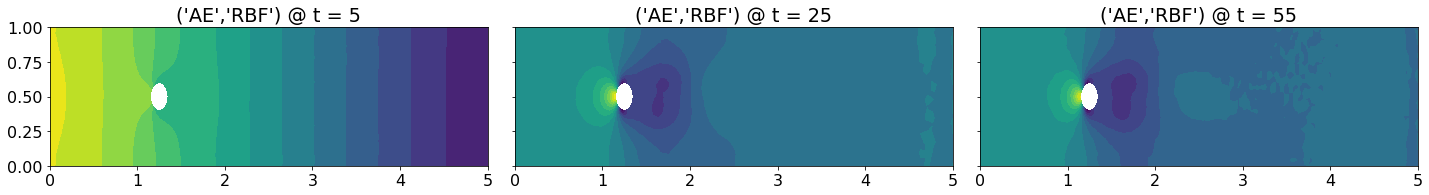

In [1]:
# Libraries
import numpy as np
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
plt.rc('font', size = 16)

from ezyrb import Database
from ezyrb.parallel import ReducedOrderModel as ROM
from ezyrb.parallel import AE_EDDL, RBF

import torch
from torch import nn

# Path to find PyEDDL library in PyCOMPSs container
import sys  
sys.path.append('/usr/local/miniconda3/lib/python3.8/site-packages') 
from pyeddl import eddl
# ----------------------------------------------------------------
def plot_triang(triang, sol):
    plt.figure(figsize=(20, 5))
#     plt.triplot(triang, 'b-', lw=0.1)
    plt.tripcolor(triang, sol);
    plt.show()
# ----------------------------------------------------------------
# Load data as NumPy arrays:
# The snapshots represented in rows
time = np.load('./data_2d/time.npy')
pts = np.load('./data_2d/pts.npy')
cells = np.load('./data_2d/cells.npy')
snapshots_pressure = np.load('./data_2d/snapshots_pressure.npy')
snapshots_vx = np.load('./data_2d/snapshots_vx.npy')
snapshots_vy = np.load('./data_2d/snapshots_vy.npy')
snapshots_vz = np.load('./data_2d/snapshots_vz.npy')

print('max cells',np.max(cells))
print('pts shape', pts.shape)
triang = mtri.Triangulation(pts[:, 0], pts[:, 1], triangles=cells)
print('Param Mat shape {}, Snap Mat sape {}'.format(time.shape, snapshots_pressure.shape))
# ----------------------------------------------------------------
# Remove snap 55 
snapshots_pressure_train = np.delete(snapshots_pressure,55,0)
time_train = np.delete(time,55,0)
# ----------------------------------------------------------------
db = Database(time_train, snapshots_pressure_train)
ae = AE_EDDL([500,100,4],[4,100,500],eddl.Tanh,eddl.Tanh,1000,5,optimizer=eddl.adam,lr=1e-4, cs=eddl.CS_CPU,training_type=2)
rbf = RBF()
rom = ROM(db, ae, rbf)
rom.fit()
l = [5,25,55]; predictions = [];
for element in l:
    predictions.append(rom.predict([element]))
# ----------------------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 3), sharey=True, sharex=True)
ax = ax.flatten()
for i in range(3):
    ax[i].tricontourf(triang, predictions[i], levels=16)
    ax[i].set_title("('AE','RBF') @ t = {}".format(l[(i)]))
plt.tight_layout()